In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import copy
import os
import pickle

import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()
u.set_enabled_equivalencies(u.dimensionless_angles())

import tdwg.lib.diffraction as diffraction
from tdwg.lib.misc_utils import custom_mkdir, arange_inclusive
from tdwg.lib.plot_utils import plot_norm, plot_norm_col
from tdwg.lib.sweeps import sweep_zip
from tdwg.lib.beams_utils import get_gaussian
from tdwg.lib.simulation import interp1d
from tdwg.lib.exp_sim_converter import Exp_Sim_Converter
import tdwg.lib.ftutils_torch as ftutils_torch
import tdwg.lib.ftutils_np as ftutils_np
from tdwg.lib.piezo_controller import TDWG_piezo_controller
import tdwg.lib.pnn_utils as pnn_utils 
from tdwg.lib.PCIe_beamshaper import PCIe_beamshaper, pos2ind
from tdwg.lib.DMD_patterns import *
from tdwg.lib.misc_utils import print_code

import torch
from pytorch_lightning import LightningModule, Trainer
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.data import TensorDataset
from tdwg.lib.multiuser_client import Client

from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder

In [4]:
from tdwg.lib.io_utils import *

In [5]:
exp_mode = "local"
# The "experimental cell"
crazy_reload("tdwg.lib.tdwgnet", globals())

from tdwg.lib.line_camera import LineCamera
import tdwg.lib.multiuser_client as client
from tdwg.lib.DMD import DMD
from tdwg.lib.misc_utils import timestring

beamshaper = PCIe_beamshaper(mode=exp_mode)
linecam = LineCamera(mode=exp_mode)
dmd = DMD(mode=exp_mode)
client = Client(online_flag=False)

Blink SDK was successfully constructed
Found 1 SLM controller(s)
Loading library: C:/Program Files/ALP-4.2/ALP-4.2 high-speed API/x64/alpV42.dll
DMD found, resolution = 1024 x 768.


## Calibration dict

In [6]:
with open('calibration_dict.pkl', 'rb') as file:
    calibration_dict = pickle.load(file)

In [7]:
#Associated with the linecam
calibration_dict["xaxis_shift"] = 30*u.um #40*u.um#35*u.um#-12*u.um #positive value "moves" experimental curve to the left!
calibration_dict["cam_mag"] = 5.354        #the magnification of the camera - fixed, Martin actually measured this with a dust spot recently!
calibration_dict["cam_mask"] = np.arange(502, 510)

calibration_dict["beamshaper_angle"] = -1.4 #-1.5
calibration_dict["phase_linear"] = -14/u.mm #-5/u.mm #4./u.mm    # An offset in the overall k-vector, for aligning DMD the beamshaper!

calibration_dict['delta_1B_SLM'] = -0.5*u.cm #0.1*u.cm was the previous number
calibration_dict['delta_2B_1F'] = -10*u.cm
calibration_dict['delta_3B_2F'] = 0*u.mm
calibration_dict['delta_3F_chip'] = 0*u.mm

#Associated with the DMD and the chip location, more precisely the "converter" object
#Most important parameters
calibration_dict["Lx"] = 4.8*u.mm
calibration_dict["Nx"] = 2**11
calibration_dict["Nz"] = 100
calibration_dict['ind_beam_center'] = 604.5 #605.5 

calibration_dict["DMD_res_z"] = 1024 #this is the resolution of the DMD in the z direction
calibration_dict["DMD_res_x"] = 768  #this is the resolution of the DMD in the x direction
calibration_dict["neff"] = 1.94      #The effective index of the material

calibration_dict["dn_rescale_factor"] = 0.95 
calibration_dict["LED_power_factor"] = 0.30 
calibration_dict["frequency_rescale_factor"] = 1.0
calibration_dict["diffusion_length"] = 9*u.um
# calibration_dict["diffusion_exponent"] = 2

calibration_dict["img_exp_pitch"] = 8.9741*u.um #13*u.um*2/3  #the pitch of the electrodes on the chip
calibration_dict["front_dist"] = 1.25*u.mm #distance from edge of green light to the edge of the chip, from the front (estimated, not precisely determined). If set as negative, that means that the green light's edge is outside of the front of the chip.
calibration_dict["back_dist"] = 1.3*u.mm #distance from edge of green light to the edge of the chip, from the back. If set as negative, that means that the green light's edge is outside of the back of the chip.
calibration_dict["front_ind_pad"] = 17 #how many indices of the DMD image will be set to zero at front - this is to not illuminate the electrode edge.
calibration_dict["back_ind_pad"] = 17 #how many indices of the DMD image will be set to zero at back - this is to not illuminate the electrode edge.

calibration_dict["bs_sleep"] = 0.03 #How long the beamshaper needs to sleep for before an image can be taken - tested that this number is OK as long as the setup is operated at 10Hz.
calibration_dict["DMD_sleep"] = 0.3 #How long the DMD needs to sleep
calibration_dict["dmd_safety_margin"] = 450 #How long the DMD needs to sleep

calibration_dict['fx_mod'] = -0./u.mm
# calibration_dict['Ein_sim_amp_cali'] = calibration_dict['Ein_sim_amp_cali'] # Ein_sim_amp_cali
# calibration_dict['Ein_sim_amp_cali'] = Ein_sim_amp_cali

#When edits are made, just load them in automatically!
if "linecam" in locals():
    linecam.load_calibration(calibration_dict)
if "converter" in locals():
    converter.load_calibration(calibration_dict)
if "beamshaper" in locals():
    beamshaper.load_calibration(calibration_dict)
if "dmd" in locals():
    dmd.load_calibration(calibration_dict)

with open('calibration_dict.pkl', 'wb') as file:
    pickle.dump(calibration_dict, file)

In [8]:
crazy_reload("tdwg.lib.tdwgnet", globals())

In [9]:
converter = Exp_Sim_Converter(calibration_dict, Ncom=3)
wg = converter.wg

tdwg_sim = FineTunedSimulation(converter)

In [10]:
tdwg_exp = TDwgExperiment(converter, linecam, beamshaper, dmd, client, calibration_dict)
tdwg_model = TDwg(tdwg_exp, tdwg_sim, "pat")

In [11]:
# This now contains the client lock
tdwg_exp.update_cam_background()

calibration_dict["cam_background"] = tdwg_exp.background

with open('calibration_dict.pkl', 'wb') as file:
    pickle.dump(calibration_dict, file)

# Helper functions

In [12]:
def make_Ein_sim(xcenter, w0, z0, f0):
    phase_term = np.exp(1j*(z0*wg.kx_axis**2/(2*calibration_dict["neff"]*wg.k0)).decompose().value)
    input_beam_sim = get_gaussian(wg.x_axis, xcenter, w0, f0)
    input_beam_sim = torch.tensor(input_beam_sim, dtype=torch.complex128)
    input_beam_sim_f = ftutils_torch.fft_centered(input_beam_sim)
    input_beam_sim_f *= phase_term
    input_beam_sim = ftutils_torch.ifft_centered(input_beam_sim_f)
    return input_beam_sim

In [13]:
save_flag = True

In [14]:
custom_mkdir("calibration_fig")

# Quick DMD check

In [15]:
from tdwg.lib.beams_utils import *
from tdwg.lib.DMD_patterns import *
import time

w0 = 40*u.um
xcenter = 0*u.um#(calibration_dict["ind_beam_center"]-455)*calibration_dict["img_exp_pitch"]
input_beam_bs = get_gaussian(beamshaper.x_bs, xcenter, w0, 0/u.mm)

ind_center_shift = int(xcenter / calibration_dict['img_exp_pitch'])

#Some of these images are useful for testing the holography setup
st_size = 10
ycenter = 605 - ind_center_shift
factor = 1.0
img_sawtooth = generate_sawtooth(2*st_size, height=st_size, ycenter=ycenter)
img_sawtooth_invert = invert_pattern(img_sawtooth)
img_off = generate_all_off()
img_on = generate_all_on()

img_bs_1 = factor*img_sawtooth
img_bs_2 = factor*img_sawtooth_invert

dmd.apply_image_hold(img_bs_1)

C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-21 5.2V_10Hz_v2\tdwg\lib\line_camera.py:243: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


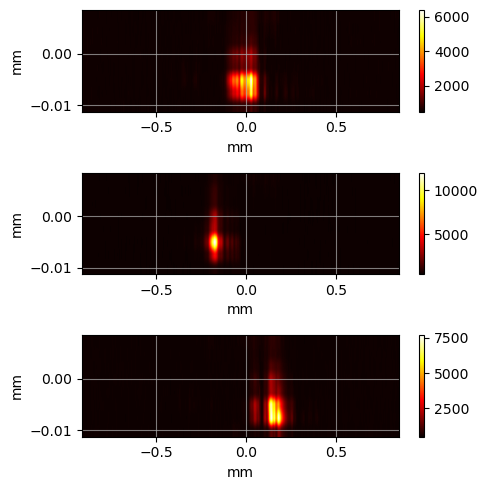

In [16]:
custom_mkdir("calibration_fig")
custom_mkdir("calibration_fig/teeth_bs")

#rewrite linecam code briefly, so we can save this stuff more easily...
fig, axs = plt.subplots(3, 1, figsize=(5, 5), dpi=100)

with client.locked():
    beamshaper.apply_Ein(input_beam_bs, 0.3)

    dmd.apply_image_hold(img_on)
    time.sleep(0.5)
    plt.sca(axs[0])
    linecam.show_image(fig_flag=False)

    dmd.apply_image_hold(img_bs_1)
    time.sleep(0.5)
    plt.sca(axs[1])
    linecam.show_image(fig_flag=False)

    dmd.apply_image_hold(img_bs_2)
    time.sleep(0.5)
    plt.sca(axs[2])
    linecam.show_image(fig_flag=False)

plt.savefig(f"calibration_fig/teeth_bs/{timestring()}.png", dpi=100, bbox_inches="tight")

In [17]:
dmd.apply_image_hold(img_on)
w0 = 40*u.um
xcenter = 0*u.um#(calibration_dict["ind_beam_center"]-455)*calibration_dict["img_exp_pitch"]
input_beam_bs = get_gaussian(beamshaper.x_bs, xcenter, w0, 0/u.mm)
beamshaper.apply_Ein(input_beam_bs, 0.03)

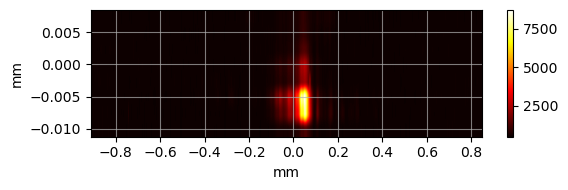

In [18]:
linecam.show_image()

In [19]:
img = generate_all_on()
img[:, calibration_dict["front_ind_pad"]] = 0
img[:, -calibration_dict["back_ind_pad"]] = 0
img[int(calibration_dict["ind_beam_center"])] = 0
# img[, :] = 0
dmd.apply_image_hold(img)

In [20]:
dmd.apply_image_hold(img_off)

## Test stability

In [21]:
def get_power(xcenter):
    w0 = 40.0*u.um
    fx = 0/u.mm
    Ein_x_th = get_gaussian(beamshaper.x_bs, xcenter, w0, fx)

    beamshaper.apply_Ein(Ein_x_th, 0.05) #0.02 is the value that I can trust so far...
    Iout_x_exp = linecam.get_output() - tdwg_exp.background
    power = np.sum(Iout_x_exp)
    return power, Iout_x_exp

In [23]:
dmd.apply_image_hold(img_off)
time.sleep(0.3)

In [24]:
with client.locked():
    t0 = time.time()
    t_list = []
    power_sta_list = []
    for i in range(100):
        power_sta_list.append(get_power(0*u.um)[0])
        t_list.append(time.time()-t0)

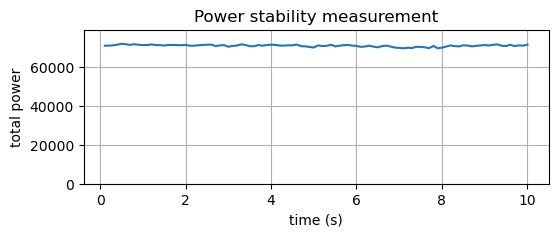

In [25]:
plt.plot(t_list, power_sta_list)
plt.ylim(bottom=0)
plt.grid()
plt.title("Power stability measurement")
plt.ylim(top=np.max(power_sta_list)*1.1)
plt.xlabel("time (s)")
plt.ylabel("total power")

if save_flag:
    plt.savefig(f"calibration_fig/power_stability_{timestring()}.png", dpi=200, bbox_inches="tight")

## Sanity check: Free-space diffraction

In [26]:
# save_flag = True
save_flag = False

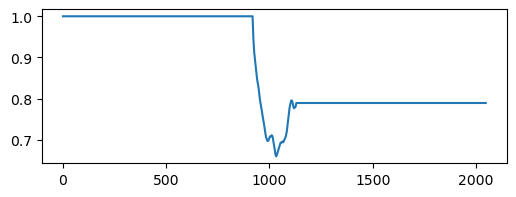

In [27]:
#see if it is still "nice"
plt.plot(calibration_dict['Ein_sim_amp_cali'])

In [28]:
w0 = 40.*u.um
xcenter = 00*u.um #(calibration_dict["ind_beam_center"]-455)*calibration_dict["img_exp_pitch"]
z0 = 0#calibration_dict["front_dist"]
fx = 0/(1*u.mm)

input_beam_sim = make_Ein_sim(xcenter, w0, z0, fx)

(-500.0, 500.0)

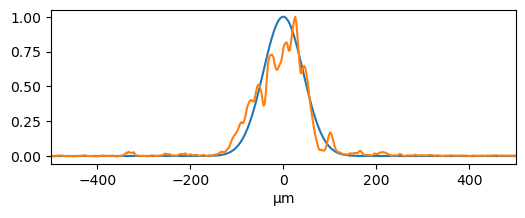

In [29]:
with client.locked():
    Iout_x_exp = tdwg_exp.run_exp(img_on, input_beam_sim)
Iout_x_sim = tdwg_sim.run_sim(img_on, input_beam_sim)

plot_norm(wg.x_axis.to("um"), Iout_x_sim.numpy())
plot_norm(wg.x_axis.to("um"), Iout_x_exp.numpy())
plt.xlim(-500, 500)

## Calibrate coupling efficiency

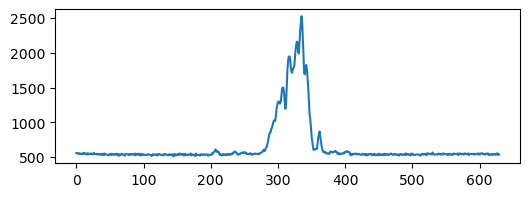

In [30]:
plt.plot(linecam.get_output())

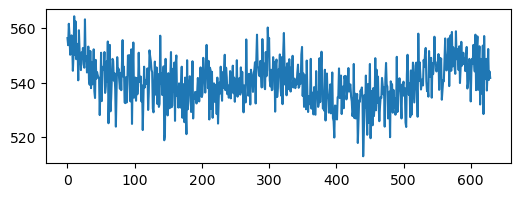

In [31]:
plt.plot(tdwg_exp.background)

In [32]:
linecam.mask_flag = True

100% 81 of 81 |#########################################| Elapsed Time: 0:00:07


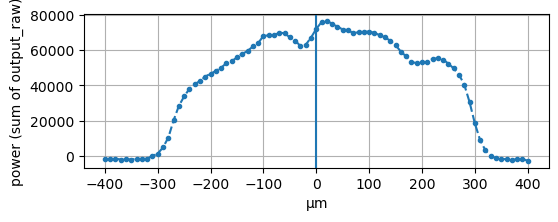

In [33]:
tdwg_exp.update_cam_background()

with client.locked():
    dmd.apply_image_hold(img_on)
    time.sleep(0.3)
    xcenter_list = arange_inclusive(-400, 400, 10)*u.um
    power_list, Iout_x_exp_list = sweep_zip(get_power, xcenter_list)   #these sweep_zip functions are convenient for simple sweeps like this

plt.plot(xcenter_list, power_list, ".--")
plt.ylabel("power (sum of output_raw)")
plt.grid()
# plt.ylim(0)
plt.axvline(0*u.um)
if save_flag:
    plt.savefig(f"calibration_fig/power_angle{beamshaper.angle:.2f}_{timestring()}.png", dpi=200, bbox_inches="tight")
plt.show()

(0.0, 1.0164852905415478)

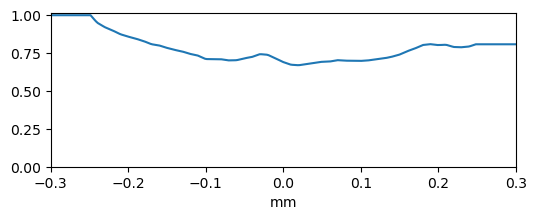

In [34]:
xlim_input = 250*u.um #this is intentionally a little low to not run into the dust!

temp = interp1d(xcenter_list.to("um"), power_list, fill_value="extrapolate")(
                wg.x_axis.to("um"))#the term to multiply by!

temp = temp/np.max(temp)
temp = 1/temp
temp[wg.x_axis > xlim_input] = 1
temp[wg.x_axis < -xlim_input] = 1
temp = temp/np.max(temp)
temp = np.sqrt(temp)

temp[wg.x_axis > xlim_input] = temp[wg.x2ind(xlim_input)-1]
temp[wg.x_axis < -xlim_input] = temp[wg.x2ind(-xlim_input)+1]
Ein_sim_amp_cali = temp

plt.plot(wg.x_axis, Ein_sim_amp_cali)
plt.xlim(-0.3, 0.3)
plt.ylim(0)

In [35]:
calibration_dict['Ein_sim_amp_cali'] = Ein_sim_amp_cali 

if "beamshaper" in locals():
    beamshaper.load_calibration(calibration_dict)

In [36]:
w0 = 30*u.um
z0 = 0*u.um
xcenter1 = -200*u.um
xcenter2 = 200*u.um
Ein_sim_1 = make_Ein_sim(xcenter1, w0, z0, 0/u.mm)
Ein_sim_2 = make_Ein_sim(xcenter2, w0, z0, 0/u.mm)

Ein_sim = Ein_sim_1 + Ein_sim_2
# Ein_sim = Ein_sim_2

(-0.3, 0.3)

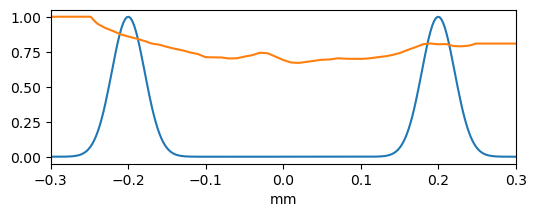

In [37]:
plt.plot(wg.x_axis, np.abs(Ein_sim))
plt.plot(wg.x_axis, Ein_sim_amp_cali)
plt.xlim(-0.3, 0.3)

## Test that this amplitude calibration does indeed work!

In [38]:
def measure_power_balance(Iout_x_exp, cut_point = 0.0*u.mm, max_point = 350*u.um, min_point = -350*u.um):
    mask_pos = (wg.x_axis > cut_point)*(wg.x_axis<max_point)
    mask_neg = (wg.x_axis < cut_point)*(wg.x_axis>min_point)
    power_pos = Iout_x_exp[mask_pos].sum()
    power_neg = Iout_x_exp[mask_neg].sum()
    power_pos_ratio = power_pos / (power_pos + power_neg)
    power_neg_ratio = power_neg / (power_pos + power_neg)
    print(f'left side: {power_neg_ratio:.3f}, right side: {power_pos_ratio:.3f}')

In [39]:
Iout_x_exp = tdwg_exp.run_exp(img_on, Ein_sim)

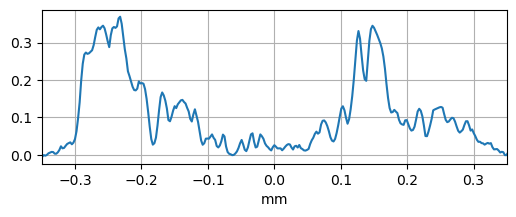

In [40]:
plt.plot(wg.x_axis, Iout_x_exp)
plt.xlim(-0.35, 0.35)
plt.grid()

In [41]:
measure_power_balance(Iout_x_exp, cut_point = 0.1*u.mm)

left side: 0.600, right side: 0.400


In [42]:
def get_power_corrected(xcenter):
    w0 = 40.0*u.um
    fx = 0/u.mm
    Ein_x_sim = get_gaussian(wg.x_axis, xcenter, w0, fx)
    Ein_x_sim *= calibration_dict['Ein_sim_amp_cali']
    Ein_x_bs = interp1d(wg.x_axis, Ein_x_sim, bounds_error=False, fill_value=0)(beamshaper.x_bs)
    _, Ein_x_SLM = beamshaper.camps_chip_to_camps_SLM(beamshaper.x_bs, Ein_x_bs, normalize = False)
    max_SLM_value = np.abs(Ein_x_SLM).max().value
    Ein_x_bs /= max_SLM_value

    beamshaper.apply_Ein(Ein_x_bs, 0.02, normalize = False)
    Iout_x_exp = linecam.get_output() - tdwg_exp.background
    Iout_x_exp *= max_SLM_value**2
    power = np.sum(Iout_x_exp)
    return power, Ein_x_sim, Iout_x_exp

100% 81 of 81 |#########################################| Elapsed Time: 0:00:08


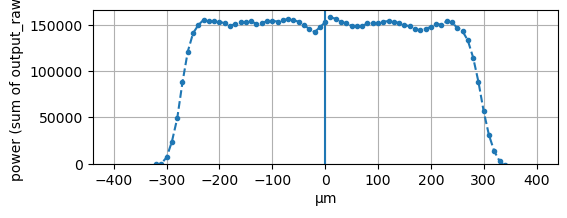

In [43]:
with client.locked():
    dmd.apply_image_hold(img_on)
    time.sleep(0.3)
    xcenter_list = arange_inclusive(-400, 400, 10)*u.um
    power_list, Ein_x_th_list, Iout_x_exp_list = sweep_zip(get_power_corrected, xcenter_list)   #these sweep_zip functions are convenient for simple sweeps like this

plt.plot(xcenter_list, power_list, ".--")
plt.ylabel("power (sum of output_raw)")
plt.grid()
plt.ylim(0)
plt.axvline(0*u.um)
if save_flag:
    plt.savefig(f"calibration_fig/power_angle{beamshaper.angle:.2f}_{timestring()}.png", dpi=200, bbox_inches="tight")
plt.show()

# Beamshaper calibration

## Calibration 1: x-k coupling to calibrate beamshaper

Here, the input position of the beam is swept, while keeping everything else fixed. 

The key goal is to ensure that the frequency domain output remains constant, while the input position is swept.
To fix it in position, modify the following parameters in the beam shaper
- calibration_dict["phase_quad"]      # Writes a focusing lens if the coefficient is negative
- calibration_dict["phase_cubic"]     # cubic factor is if you notice a strong quadratic trend in the dynamics 

In [44]:
tdwg_exp.update_cam_background()

In [45]:
from tdwg.lib.io_utils import crazy_reload
from tdwg.lib.misc_utils import print_code

In [46]:
crazy_reload('tdwg.lib.plot_utils', globals())

In [47]:
w0 = 40*u.um
xcenter = 0*u.um #(calibration_dict["ind_beam_center"]-455)*calibration_dict["img_exp_pitch"]
z0 = calibration_dict["front_dist"]
fx = 0/(1*u.mm)

input_beam_sim = make_Ein_sim(xcenter, w0, z0, fx)

In [48]:
with client.locked():
    dmd.apply_image_hold(img_on)
    time.sleep(0.3)

    mod_sim_whole = converter.img_2_mod_sim_whole(img_off)
    delta_n = converter.mod_sim_whole_2_delta_n(mod_sim_whole)
    wg.set_delta_n(delta_n)

    xcenter_list = arange_inclusive(-300, 300, 40)*u.um
    Ein_x_th_list = torch.stack([make_Ein_sim(xcenter, w0, z0, fx) for xcenter in xcenter_list])

    Iout_x_exp_list = tdwg_exp.run_exp_fixed_DMD_list_fast(Ein_x_th_list)
    Iout_x_th_list = tdwg_sim.run_sim_fixed_DMD(Ein_x_th_list)

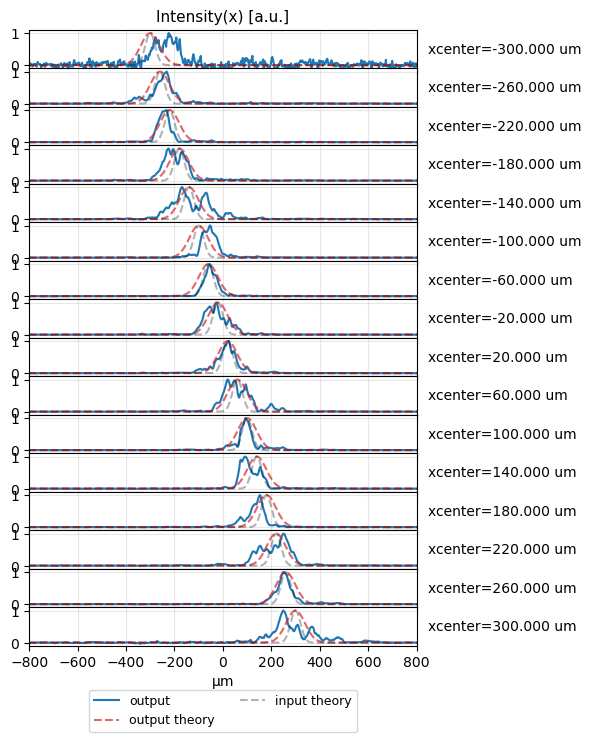

In [49]:
xaxis_th = wg.x_axis

# Plot the data collected here!
Iin_x_th_list = [abs(Ein_x_th)**2 for Ein_x_th in Ein_x_th_list]
xs = [xaxis_th.to("um")]*3
ys = [Iout_x_exp_list, Iout_x_th_list, Iin_x_th_list]

args_list = ["", "--", "--k"]
kwargs_list = [dict(c="tab:blue", label="output"), 
               dict(c="tab:red", alpha=0.7, label="output theory"), 
               dict(alpha=0.3, label="input theory")]

title_list = [f"xcenter={xcenter:.3f}" for xcenter in xcenter_list]
suptitle = "Intensity(x) [a.u.]"

fig, axs = plot_norm_col(xs, ys, row_height=0.5, title_list=title_list, args_list=args_list, kwargs_list=kwargs_list, suptitle=suptitle);
[ax.set_xlim(-800, 800) for ax in axs];

if save_flag:
    plt.savefig(f"calibration_fig/xk_{timestring()}.png", dpi=200, bbox_inches="tight")

## Calibration 2: Perform sweep of the center frequency

This is mostly a "check" and I don't tune much parameters unless the results look terrible. 
If things didn't match at all, this could be an indication that the chip_length or the effective index is horribly miscalibrated. 

The results also should "agree" with the previous calibration. For instance, we see that there is kind of junk on the positive x direction, so more problem is seen when light is sent in the positive fx initial condition. 

In [50]:
with client.locked():
    xcenter = 0*u.um
    w0 = 40*u.um
    fx_list = arange_inclusive(-90, 90, 15)/u.mm
    # fx_list = arange_inclusive(-90, 90, 2)/u.mm
    z0 = 0*u.um #calibration_dict["front_dist"]

    Ein_x_th_list = torch.stack([make_Ein_sim(xcenter, w0, z0, fx) for fx in fx_list])

    dmd.apply_image_hold(img_on)
    time.sleep(0.3)

    mod_sim_whole = converter.img_2_mod_sim_whole(img_off)
    delta_n = converter.mod_sim_whole_2_delta_n(mod_sim_whole)
    wg.set_delta_n(delta_n)

    Iout_x_exp_list = tdwg_exp.run_exp_fixed_DMD_list_fast(Ein_x_th_list)
    Iout_x_th_list = tdwg_sim.run_sim_fixed_DMD(Ein_x_th_list)

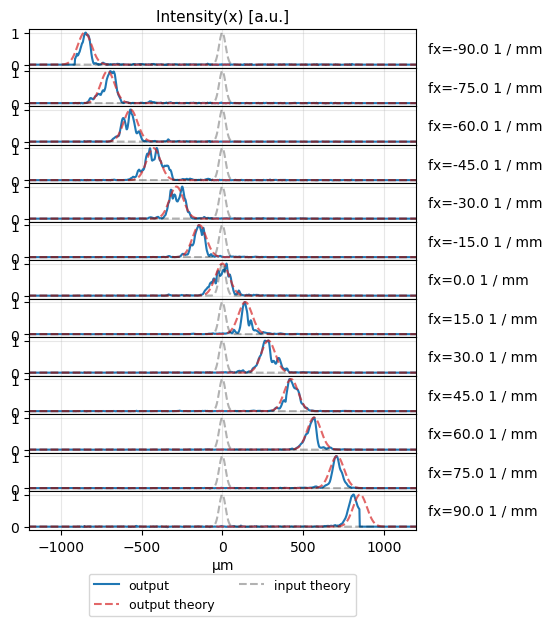

In [51]:
# Plot the data collected here!
Iin_x_th_list = [abs(Ein_x_th)**2 for Ein_x_th in Ein_x_th_list]
xs = [xaxis_th.to("um")]*3
ys = [Iout_x_exp_list, Iout_x_th_list, torch.stack(Iin_x_th_list).numpy()]

args_list = ["", "--", "--k"]
kwargs_list = [dict(c="tab:blue", label="output"), 
                dict(c="tab:red", alpha=0.7, label="output theory"), 
                dict(alpha=0.3, label="input theory")]

title_list = [f"fx={fx:.1f}" for fx in fx_list]
suptitle = "Intensity(x) [a.u.]"

fig, axs = plot_norm_col(xs, ys, row_height=0.5, title_list=title_list, args_list=args_list, kwargs_list=kwargs_list, suptitle=suptitle);
[ax.set_xlim(-1200, 1200) for ax in axs];

if save_flag:
    plt.savefig(f"calibration_fig/fx_{timestring()}.png", dpi=200, bbox_inches="tight")

## Random inputs

In [52]:
def make_random_input_beam(seed, df=1/(50*u.um), xrange=60*u.um):
    np.random.seed(seed)
    
    input_beam = np.random.randn(len(wg.x_axis)) + 1j*np.random.randn(len(wg.x_axis))
    input_beam[wg.x_axis>xrange] = 0
    input_beam[wg.x_axis<-xrange] = 0

    input_beam_f = ftutils_np.fft_centered(input_beam)
    input_beam_f = input_beam_f*np.exp(-(wg.fx_axis)**2/(2*df**2))

    input_beam = ftutils_np.ifft_centered(input_beam_f)

    input_beam /= np.max(np.abs(input_beam))
    return torch.tensor(input_beam, dtype=torch.cfloat)

In [53]:
input_beam = make_random_input_beam(0)

In [54]:
Ein_x_th_list = torch.stack([make_random_input_beam(seed) for seed in np.arange(15)])

with client.locked():
    dmd.apply_image_hold(img_on)
    time.sleep(0.3)

    mod_sim_whole = converter.img_2_mod_sim_whole(img_on)
    delta_n = converter.mod_sim_whole_2_delta_n(mod_sim_whole)
    wg.set_delta_n(delta_n)

    Iout_x_exp_list = tdwg_exp.run_exp_fixed_DMD_list_fast(Ein_x_th_list)
    Iout_x_th_list = tdwg_sim.run_sim_fixed_DMD(Ein_x_th_list)

C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-21 5.2V_10Hz_v2\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
4 pixels are saturated!
  warnings.warn(warn_msg)


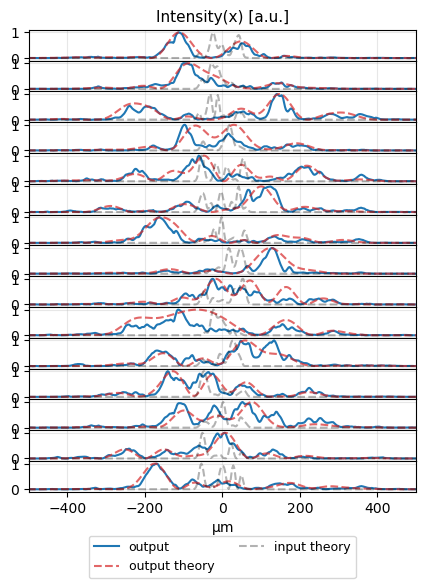

In [55]:
# Plot the data collected here!
Iin_x_th_list = [abs(Ein_x_th)**2 for Ein_x_th in Ein_x_th_list]
xs = [xaxis_th.to("um")]*3
ys = [Iout_x_exp_list, Iout_x_th_list, torch.stack(Iin_x_th_list).numpy()]

args_list = ["", "--", "--k"]
kwargs_list = [dict(c="tab:blue", label="output"), 
                dict(c="tab:red", alpha=0.7, label="output theory"), 
                dict(alpha=0.3, label="input theory")]

suptitle = "Intensity(x) [a.u.]"

fig, axs = plot_norm_col(xs, ys, row_height=0.4, args_list=args_list, kwargs_list=kwargs_list, suptitle=suptitle);
[ax.set_xlim(-500, 500) for ax in axs];

if save_flag:
    plt.savefig(f"calibration_fig/exotic_inputs_{timestring()}.png", dpi=200, bbox_inches="tight")

## Focus beam at different locations inside waveguide

In [56]:
xcenter = 0*u.um
w0 = 20*u.um
fx = 0/u.mm
z0_list = np.linspace(0, 20, 10)*u.mm 

Ein_x_th_list = [make_Ein_sim(xcenter, w0, z0, fx) for z0 in z0_list]

In [57]:
with client.locked():
    dmd.apply_image_hold(img_on)

    mod_sim_whole = converter.img_2_mod_sim_whole(img_off)
    delta_n = converter.mod_sim_whole_2_delta_n(mod_sim_whole)
    wg.set_delta_n(delta_n)

    Iout_x_exp_list = sweep_zip(tdwg_exp.run_exp_fixed_DMD, Ein_x_th_list)
Iout_x_th_list = sweep_zip(tdwg_sim.run_sim_fixed_DMD, Ein_x_th_list)

 30% 3 of 10 |############                              | Elapsed Time: 0:00:00C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-21 5.2V_10Hz_v2\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
17 pixels are saturated!
  warnings.warn(warn_msg)
 40% 4 of 10 |################                          | Elapsed Time: 0:00:00C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-21 5.2V_10Hz_v2\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
19 pixels are saturated!
  warnings.warn(warn_msg)
 50% 5 of 10 |#####################                     | Elapsed Time: 0:00:00C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-21 5.2V_10Hz_v2\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
18 pixels are saturated!
  warnings.warn(warn_msg)
 60% 6 of 10 |#########################                 | Elapsed Time: 0:00:00C:\Users\McMahon-l

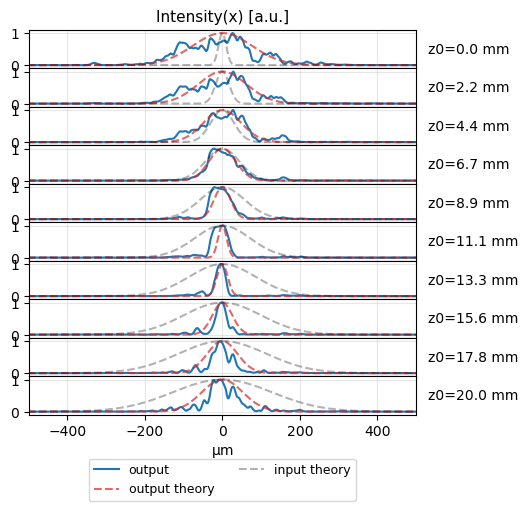

In [58]:
# Plot the data collected here!
Iin_x_th_list = [abs(Ein_x_th)**2 for Ein_x_th in Ein_x_th_list]
xs = [xaxis_th.to("um")]*3
ys = [Iout_x_exp_list, Iout_x_th_list, torch.stack(Iin_x_th_list).numpy()]

args_list = ["", "--", "--k"]
kwargs_list = [dict(c="tab:blue", label="output"), 
                dict(c="tab:red", alpha=0.7, label="output theory"), 
                dict(alpha=0.3, label="input theory")]

title_list = [f"z0={z0:.1f}" for z0 in z0_list]
suptitle = "Intensity(x) [a.u.]"

fig, axs = plot_norm_col(xs, ys, row_height=0.5, title_list=title_list, args_list=args_list, kwargs_list=kwargs_list, suptitle=suptitle);
[ax.set_xlim(-500, 500) for ax in axs];

if save_flag:
    plt.savefig(f"calibration_fig/gaussianw0_{timestring()}.png", dpi=200, bbox_inches="tight")

# DMD calibration


In [59]:
dmd.apply_image_hold(img_off)
dmd.apply_image_hold(img_on)

In [60]:
w0 = 40*u.um
xcenter = 0*u.um#(calibration_dict["ind_beam_center"]-455)*calibration_dict["img_exp_pitch"]
input_beam_bs = get_gaussian(beamshaper.x_bs, xcenter, w0, 0/u.mm)

ind_center_shift = int(xcenter / calibration_dict['img_exp_pitch'])

#Some of these images are useful for testing the holography setup
st_size = 10
ycenter = 605 - ind_center_shift
factor = 1.0
img_sawtooth = generate_sawtooth(2*st_size, height=st_size, ycenter=ycenter)
img_sawtooth_invert = invert_pattern(img_sawtooth)
img_off = generate_all_off()
img_on = generate_all_on()

img_bs_1 = factor*img_sawtooth
img_bs_2 = factor*img_sawtooth_invert

dmd.apply_image_hold(img_bs_1)

In [61]:
def show_image_local():
    cmap = "hot"
    self = linecam
    cam_img = self.get_image()

    vmax = cam_img.max()
    xaxis = self.get_xaxis().value
    yaxis = self.get_yaxis().value
    Ny = np.shape(cam_img)[0]
    
    im = plt.imshow(cam_img, cmap=cmap, aspect="auto",
                    extent=[xaxis.min(), xaxis.max(), yaxis.min(), yaxis.max()], vmax=vmax)

    plt.xlabel("mm")
    plt.ylabel("mm")
    plt.grid(alpha=0.7)

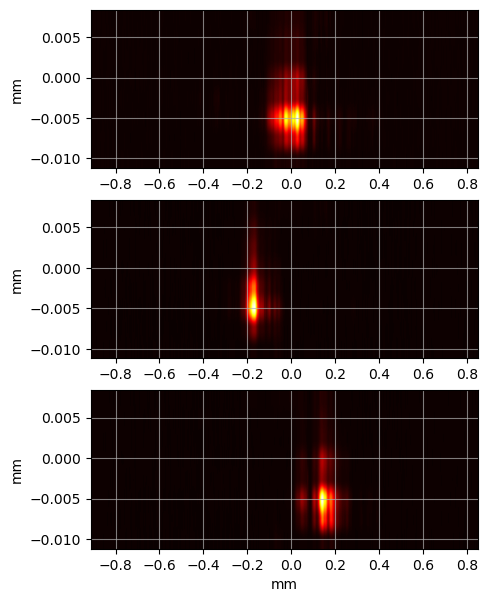

In [62]:
fig, axs = plt.subplots(3, 1, figsize=(5, 7), dpi=100)
with client.locked():
    beamshaper.apply_Ein(input_beam_bs, 0.3)

    dmd.apply_image_hold(img_on)
    time.sleep(0.5)
    plt.sca(axs[0])
    show_image_local()

    dmd.apply_image_hold(img_bs_1)
    time.sleep(0.5)
    plt.sca(axs[1])
    show_image_local()

    dmd.apply_image_hold(img_bs_2)
    time.sleep(0.5)
    plt.sca(axs[2])
    show_image_local()

if save_flag:
    plt.savefig(f"calibration_fig/teeth_bs_{timestring()}.png", dpi=200, bbox_inches="tight")

In [63]:
# dmd.apply_image_hold(img_off)
# dmd.apply_image_hold(img_on)

In [64]:
# save_flag = True

# Testing

In [65]:
w0 = 40.*u.um
xcenter = 00*u.um #(calibration_dict["ind_beam_center"]-455)*calibration_dict["img_exp_pitch"]
z0 = 0#calibration_dict["front_dist"]
fx = 0/(1*u.mm)

input_beam_sim = make_Ein_sim(xcenter, w0, z0, fx)

(-500.0, 500.0)

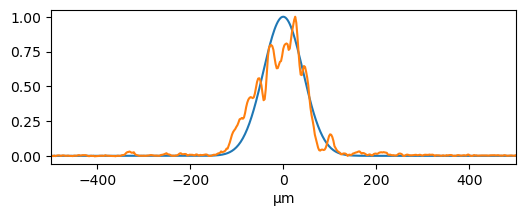

In [66]:
with client.locked():
    Iout_x_exp = tdwg_exp.run_exp(img_on, input_beam_sim)
Iout_x_sim = tdwg_sim.run_sim(img_on, input_beam_sim)

plot_norm(wg.x_axis.to("um"), Iout_x_sim.numpy())
plot_norm(wg.x_axis.to("um"), Iout_x_exp.numpy())
plt.xlim(-500, 500)

## Write GRIN beam steerers!

In [22]:
len_inds = 116 #this corresponds to about a 1mm on the chip
start_pad = calibration_dict["front_ind_pad"] #just tested that 40 works fine, decrease it to this later on! 
back_pad =  calibration_dict["back_ind_pad"]
front_zinds = np.arange(start_pad, start_pad+len_inds) #indices that will be applied for the beamsteerer, when used in "front" mode
back_zinds = np.arange(calibration_dict["DMD_res_z"]-back_pad-len_inds, calibration_dict["DMD_res_z"]-back_pad)      #indices that will be applied for the beamsteerer, when used in "back" mode
other_zinds = np.arange(calibration_dict["DMD_res_z"]-back_pad-len_inds-130, calibration_dict["DMD_res_z"]-back_pad-130)      #indices that will be applied for the beamsteerer, when used in "back" mode

In [23]:
def make_img(factor, z_inds, cut_ind, width_one_side, slope_positive):
    img = generate_grin_beamsteerer(z_inds, cut_ind, width_one_side, slope_positive)
    img =(factor*img).astype(np.uint8)
    return img

(425.0, 437.0)

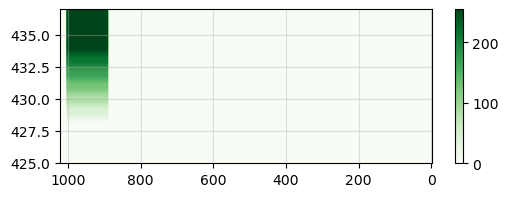

In [24]:
# Demo block, showing the beamsteerer
cut_ind = 431
factor = 1.0
width_one_side = 3
slope_positive = True
img = make_img(factor, back_zinds, cut_ind, width_one_side, slope_positive)
plot_DMD_img(img)
plt.ylim(cut_ind-width_one_side*2, cut_ind+width_one_side*2)

In [25]:
###### IMPORTANT KEY PARAMETERS of sweep ######
factor = 1.0
width_one_side = 1
slope_positive = True
xcenter = 0*u.um

In [26]:
################# Define input beam ################
input_beam_sim = torch.tensor(get_gaussian(wg.x_axis, xcenter, 40*u.um, 0/u.mm), dtype=torch.cfloat)

cut_ind_list = list(arange_inclusive(590-ind_center_shift, 620-ind_center_shift, 2))
img_front_list = [make_img(factor, front_zinds, cut_ind, width_one_side, slope_positive) for cut_ind in cut_ind_list]
input_beam_bs_front_list = [input_beam_sim for cut_ind in cut_ind_list] #a trivial repeat as I want the same input

In [27]:
with client.locked():
    Iout_x_exp_list = sweep_zip(tdwg_exp.run_exp, img_front_list, input_beam_bs_front_list)

100% 16 of 16 |#########################################| Elapsed Time: 0:00:06


In [28]:
Iout_x_sim_list = sweep_zip(tdwg_sim.run_sim, img_front_list, input_beam_bs_front_list)

100% 16 of 16 |#########################################| Elapsed Time: 0:00:01


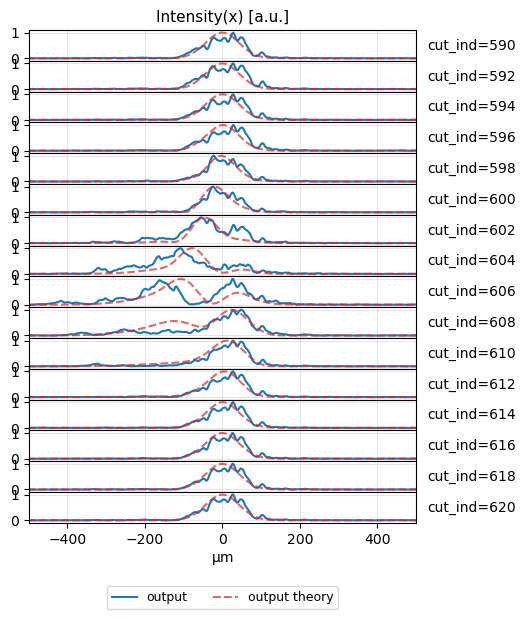

In [29]:
# Plot the data collected here!
xs = [wg.x_axis.to("um")]*2
ys = [Iout_x_exp_list, Iout_x_sim_list]

args_list = ["", "--"]
kwargs_list = [dict(c="tab:blue", label="output"), 
                dict(c="tab:red", alpha=0.7, label="output theory")
              ]

title_list = [f"cut_ind={cut_ind:.0f}" for cut_ind in cut_ind_list]
suptitle = "Intensity(x) [a.u.]"

fig, axs = plot_norm_col(xs, ys, row_height=0.4, args_list=args_list, kwargs_list=kwargs_list, suptitle=suptitle, title_list=title_list);
[ax.set_xlim(-500, 500) for ax in axs];

if save_flag:
    plt.savefig(f"calibration_fig/grin_bs_front{timestring()}.png", dpi=200, bbox_inches="tight")

In [30]:
################# Define input beam ################
img_back_list = [make_img(factor, back_zinds, cut_ind, width_one_side, slope_positive) for cut_ind in cut_ind_list]
input_beam_bs_back_list = [input_beam_sim for cut_ind in cut_ind_list] #a trivial repeat as I want the same input

In [31]:
with client.locked():
    Iout_x_exp_list = sweep_zip(tdwg_exp.run_exp, img_back_list, input_beam_bs_back_list)

 37% 6 of 16 |###############                           | Elapsed Time: 0:00:02C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-21 5.2V_10Hz_v2\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
3 pixels are saturated!
  warnings.warn(warn_msg)
100% 16 of 16 |#########################################| Elapsed Time: 0:00:06


In [32]:
Iout_x_sim_list = sweep_zip(tdwg_sim.run_sim, img_back_list, input_beam_bs_back_list)

100% 16 of 16 |#########################################| Elapsed Time: 0:00:01


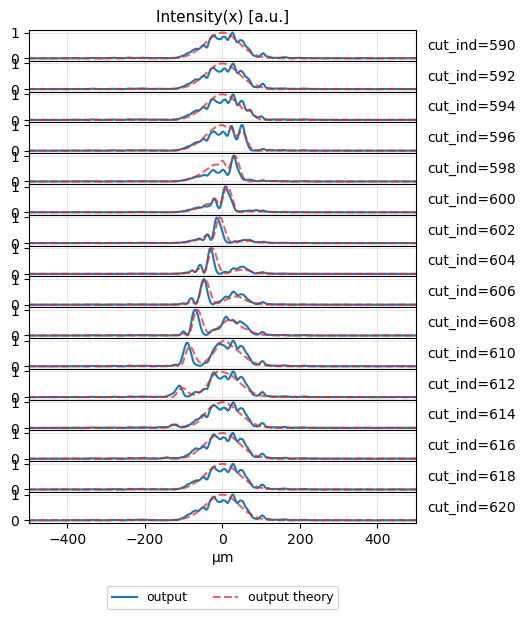

In [33]:
# Plot the data collected here!
xs = [wg.x_axis.to("um")]*2
ys = [Iout_x_exp_list, Iout_x_sim_list]

args_list = ["", "--"]
kwargs_list = [dict(c="tab:blue", label="output"), 
                dict(c="tab:red", alpha=0.7, label="output theory")
              ]

title_list = [f"cut_ind={cut_ind:.0f}" for cut_ind in cut_ind_list]
suptitle = "Intensity(x) [a.u.]"

fig, axs = plot_norm_col(xs, ys, row_height=0.4, args_list=args_list, kwargs_list=kwargs_list, suptitle=suptitle, title_list=title_list);
[ax.set_xlim(-500, 500) for ax in axs];

if save_flag:
    plt.savefig(f"calibration_fig/grin_bs_back{timestring()}.png", dpi=200, bbox_inches="tight")

# Inverse waveguide

In [34]:
def make_iwg_img(factor, ind, width = 1, start_ind=calibration_dict["front_ind_pad"]):
    """
    iwg stands for inverted wg
    """
    img = factor*copy.deepcopy(generate_all_on())
    img[ind - int(width/2):ind + int(width/2 + 0.5), start_ind:-calibration_dict["back_ind_pad"]] = 0
    img = img.astype(np.uint8)
    return img

In [35]:
#Ok, so this requires understanding the API a little better...

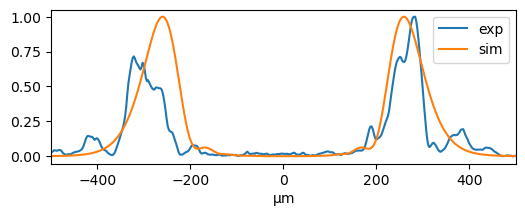

C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-21 5.2V_10Hz_v2\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
15 pixels are saturated!
  warnings.warn(warn_msg)


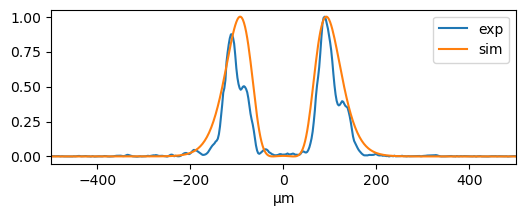

In [36]:
factor = 1.0
start_ind = 50 
img_iwg_front = make_iwg_img(factor, 605, start_ind=start_ind, width=4)

w0 = 15*u.um
xcenter = (calibration_dict["ind_beam_center"]-605+0.5)*calibration_dict["img_exp_pitch"]
z0_front = calibration_dict["img_exp_pitch"]*start_ind+calibration_dict["front_dist"]
input_beam_sim = make_Ein_sim(xcenter, w0, z0_front, 0/u.mm)

with client.locked():
    Iout_x_exp_front = tdwg_exp.run_exp(img_iwg_front, input_beam_sim)
Iout_x_sim_front, wg_front = tdwg_sim.run_sim_slow(img_iwg_front, input_beam_sim)

plot_norm(wg.x_axis.to("um"), Iout_x_exp_front, label="exp")
plot_norm(wg.x_axis.to("um"), Iout_x_sim_front, label="sim")
plt.xlim(-500, 500)
plt.legend()
plt.show()

start_ind = 500
img_iwg_back = make_iwg_img(factor, 605, start_ind=start_ind, width=2)

z0_back= calibration_dict["img_exp_pitch"]*start_ind+calibration_dict["front_dist"]
input_beam_sim = make_Ein_sim(xcenter, w0, z0_back, 0/u.mm)

with client.locked():
    Iout_x_exp_back = tdwg_exp.run_exp(img_iwg_back, input_beam_sim)
Iout_x_sim_back, wg_back = tdwg_sim.run_sim_slow(img_iwg_back, input_beam_sim)

plot_norm(wg.x_axis.to("um"), Iout_x_exp_back, label="exp")
plot_norm(wg.x_axis.to("um"), Iout_x_sim_back, label="sim")
plt.xlim(-500, 500)
plt.legend()

(<Figure size 1200x200 with 4 Axes>,
 array([<Axes: title={'center': '$\\Delta n\\ \\  (10^{-3})$'}, xlabel='z (mm)', ylabel='x (um)'>,
        <Axes: title={'center': 'Spatial intensity'}, xlabel='z (mm)', ylabel='x (um)'>,
        <Axes: title={'center': 'Wavevector intensity'}, xlabel='z (mm)', ylabel='f (1/mm)'>],
       dtype=object))

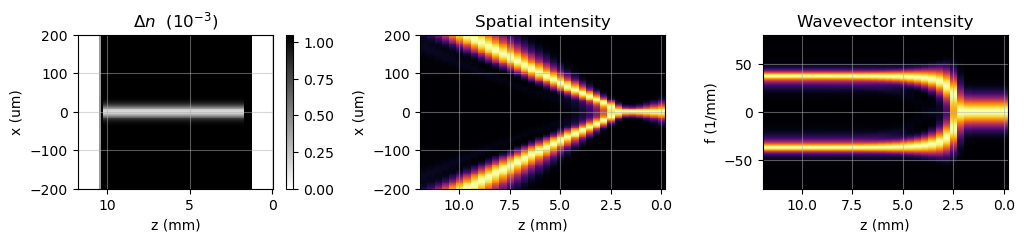

In [37]:
wg_front.plot_mats(xlim=200)

(<Figure size 1200x200 with 4 Axes>,
 array([<Axes: title={'center': '$\\Delta n\\ \\  (10^{-3})$'}, xlabel='z (mm)', ylabel='x (um)'>,
        <Axes: title={'center': 'Spatial intensity'}, xlabel='z (mm)', ylabel='x (um)'>,
        <Axes: title={'center': 'Wavevector intensity'}, xlabel='z (mm)', ylabel='f (1/mm)'>],
       dtype=object))

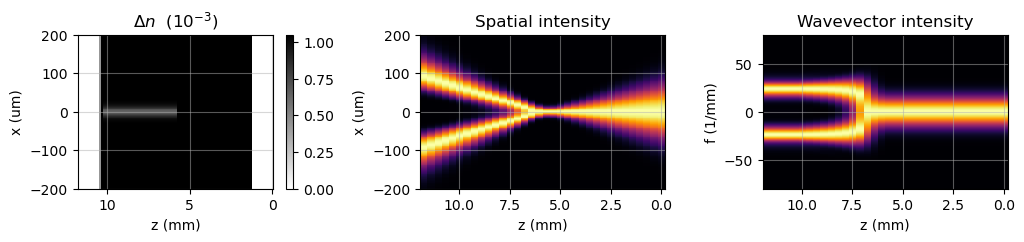

In [38]:
wg_back.plot_mats(xlim=200)

## Sweep factor

In [39]:
factor_list = arange_inclusive(0, 1, 0.10)
start_ind = 50
img_iwg_list = [make_iwg_img(factor, 605, start_ind=start_ind, width=2) for factor in factor_list]

w0 = 10*u.um
xcenter = (calibration_dict["ind_beam_center"]-605+0.5)*calibration_dict["img_exp_pitch"]
z0_front = calibration_dict["img_exp_pitch"]*calibration_dict["front_ind_pad"]+calibration_dict["front_dist"]
input_beam_sim = make_Ein_sim(xcenter, w0, z0_front, 0/u.mm)
input_beam_list = [input_beam_sim] * len(factor_list)

In [40]:
# from tdwg.lib.plot_utils import plot_norm, plot_norm_col

In [41]:
with client.locked():
    Iout_x_exp_list = sweep_zip(tdwg_exp.run_exp, img_iwg_list, input_beam_list)

 18% 2 of 11 |#######                                   | Elapsed Time: 0:00:00C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-21 5.2V_10Hz_v2\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
9 pixels are saturated!
  warnings.warn(warn_msg)
 27% 3 of 11 |###########                               | Elapsed Time: 0:00:00C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-21 5.2V_10Hz_v2\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
21 pixels are saturated!
  warnings.warn(warn_msg)
 36% 4 of 11 |###############                           | Elapsed Time: 0:00:01C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-21 5.2V_10Hz_v2\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
19 pixels are saturated!
  warnings.warn(warn_msg)
 45% 5 of 11 |###################                       | Elapsed Time: 0:00:01C:\Users\McMahon-la

In [42]:
Iout_x_sim_list = sweep_zip(tdwg_sim.run_sim, img_iwg_list, input_beam_list)

100% 11 of 11 |#########################################| Elapsed Time: 0:00:00


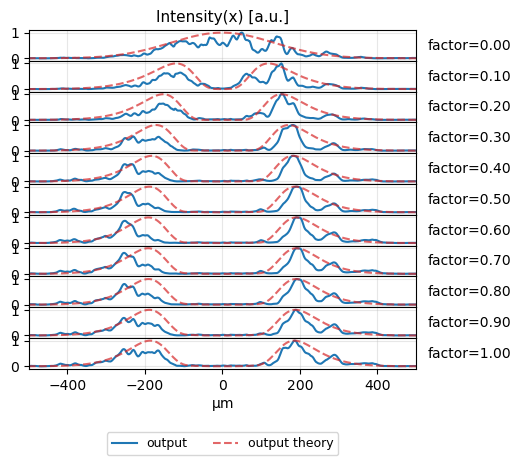

In [43]:
# Plot the data collected here!
xs = [wg.x_axis.to("um")]*2
ys = [Iout_x_exp_list, Iout_x_sim_list]

args_list = ["", "--"]
kwargs_list = [dict(c="tab:blue", label="output", mode = 'max'), 
                dict(c="tab:red", alpha=0.7, label="output theory", mode = 'max')
              ]

title_list = [f"factor={factor:.2f}" for factor in factor_list]
suptitle = "Intensity(x) [a.u.]"

fig, axs = plot_norm_col(xs, ys, row_height=0.4, args_list=args_list, kwargs_list=kwargs_list, suptitle=suptitle, title_list=title_list);
[ax.set_xlim(-500, 500) for ax in axs];

if save_flag:
    plt.savefig(f"calibration_fig/inverse_wg_front_{timestring()}.png", dpi=200, bbox_inches="tight")

In [44]:
# save_flag = False

In [45]:
start_ind = 500
img_iwg_back_list = [make_iwg_img(factor, 605, start_ind = start_ind, width=2) for factor in factor_list]

w0 = 10*u.um
xcenter = (calibration_dict["ind_beam_center"]-605+0.5)*calibration_dict["img_exp_pitch"]
z0_back= calibration_dict["img_exp_pitch"]*start_ind+calibration_dict["front_dist"]
input_beam_sim = make_Ein_sim(xcenter, w0, z0_back, 0/u.mm)
input_beam_list = [input_beam_sim] * len(factor_list)

In [46]:
with client.locked():
    Iout_x_exp_list = sweep_zip(tdwg_exp.run_exp, img_iwg_back_list, input_beam_list)

C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-21 5.2V_10Hz_v2\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
22 pixels are saturated!
  warnings.warn(warn_msg)
 18% 2 of 11 |#######                                   | Elapsed Time: 0:00:00C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-21 5.2V_10Hz_v2\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
24 pixels are saturated!
  warnings.warn(warn_msg)
 27% 3 of 11 |###########                               | Elapsed Time: 0:00:00C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-21 5.2V_10Hz_v2\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
28 pixels are saturated!
  warnings.warn(warn_msg)
 45% 5 of 11 |###################                       | Elapsed Time: 0:00:01C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-21 5.2V_10Hz_v2

In [47]:
Iout_x_sim_list = sweep_zip(tdwg_sim.run_sim, img_iwg_back_list, input_beam_list)

100% 11 of 11 |#########################################| Elapsed Time: 0:00:00


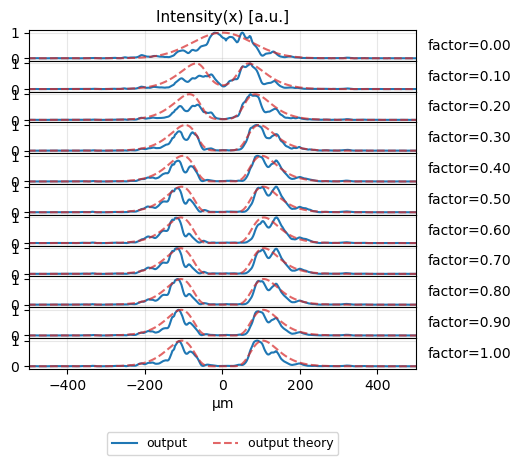

In [48]:
# Plot the data collected here!
xs = [wg.x_axis.to("um")]*2
ys = [Iout_x_exp_list, Iout_x_sim_list]

args_list = ["", "--"]
kwargs_list = [dict(c="tab:blue", label="output", mode = 'max'), 
                dict(c="tab:red", alpha=0.7, label="output theory", mode = 'max')
              ]

title_list = [f"factor={factor:.2f}" for factor in factor_list]
suptitle = "Intensity(x) [a.u.]"

fig, axs = plot_norm_col(xs, ys, row_height=0.4, args_list=args_list, kwargs_list=kwargs_list, suptitle=suptitle, title_list=title_list);
[ax.set_xlim(-500, 500) for ax in axs];

if save_flag:
    plt.savefig(f"calibration_fig/inverse_wg_back_{timestring()}.png", dpi=200, bbox_inches="tight")

# Plot deltaN func

In [118]:
power_list = np.linspace(0, 5, 100)
dn_norm_list = converter.dn_norm_func(power_list)

(0.0, 1.0)

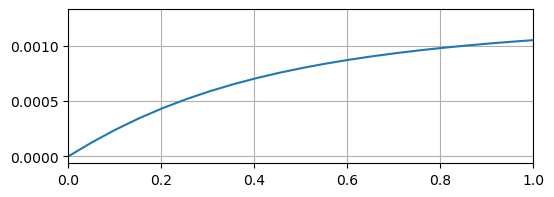

In [119]:
plt.plot(power_list, dn_norm_list)
plt.grid()

if save_flag:
    plt.savefig(f"calibration_fig/delta_n{timestring()}.png", dpi=200, bbox_inches="tight")
# plt.ylim(top=10e-4)
plt.xlim(0,1)

In [101]:
dmd.safety_margin

450

In [95]:
dmd.apply_image_hold(img_on)

# Control beam

In [102]:
save_flag = False

In [103]:
img = generate_all_off()
dmd.apply_image_hold(img)

xcenter = 0*u.um #-0*9*u.um #4*u.um
w0 = 15*u.um
# input_beam_sim = make_Ein_sim(xcenter, w0, 0*u.um, 0/u.mm)
input_beam_sim = make_Ein_sim(xcenter, w0, calibration_dict["front_dist"], 0/u.mm)

In [104]:
Iout_x_exp = tdwg_exp.run_exp(img, input_beam_sim)

In [106]:
Iout_x_sim = tdwg_sim.run_sim(img, input_beam_sim)

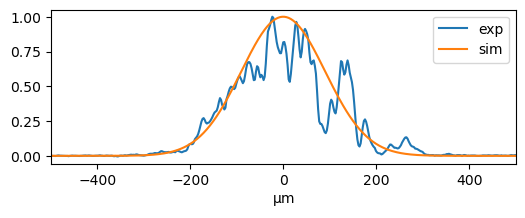

In [107]:
plot_norm(wg.x_axis.to("um"), Iout_x_exp, label="exp")
plot_norm(wg.x_axis.to("um"), Iout_x_sim, label="sim")
plt.xlim(-500, 500)
plt.legend()

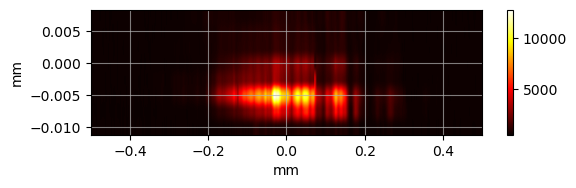

In [109]:
linecam.mask_flag = True
linecam.show_image()
plt.xlim(-0.5, 0.5)
linecam.mask_flag = True

(<Figure size 1200x200 with 4 Axes>,
 array([<Axes: title={'center': '$\\Delta n\\ \\  (10^{-3})$'}, xlabel='z (mm)', ylabel='x (um)'>,
        <Axes: title={'center': 'Spatial intensity'}, xlabel='z (mm)', ylabel='x (um)'>,
        <Axes: title={'center': 'Wavevector intensity'}, xlabel='z (mm)', ylabel='f (1/mm)'>],
       dtype=object))

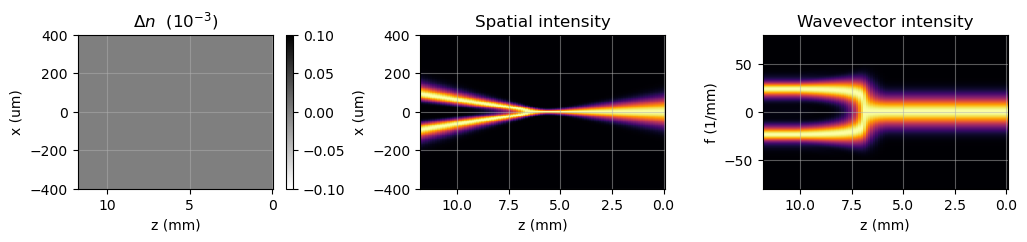

In [110]:
wg.plot_mats(xlim=400)

# Realize a waveguide!

In [111]:
# calibration_dict["xaxis_shift"] = 5*u.um#-12*u.um #positive value "moves" experimental curve to the left!
# linecam.load_calibration(calibration_dict)

In [112]:
def make_wg_img(factor, ind, width = 1):
    """
    iwg stands for inverted wg
    """
    img = generate_all_off()
    img[ind - int(width/2):ind + int(width/2 + 0.5), calibration_dict["front_ind_pad"]:-calibration_dict["back_ind_pad"]] = 255*factor
    img = img.astype(np.uint8)
    return img

In [202]:
center_px = int(np.round(calibration_dict['ind_beam_center'])) 
img = make_wg_img(1.0, center_px, 1)
# img = generate_all_off()

In [203]:
dmd.apply_image_hold(img)

In [204]:
xcenter = (calibration_dict['ind_beam_center'] - center_px) * calibration_dict['img_exp_pitch'] 
input_beam_sim = make_Ein_sim(xcenter, w0, calibration_dict["front_dist"], 0/u.mm)

In [205]:
Iout_x_exp = tdwg_exp.run_exp(img, input_beam_sim)

In [206]:
Iout_x_sim = tdwg_sim.run_sim(img, input_beam_sim)

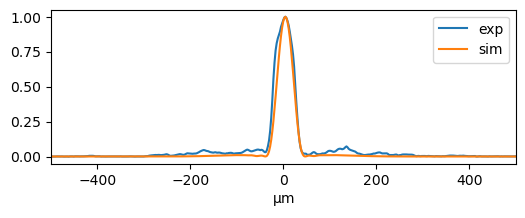

Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\Users\McMahon-lab\.conda\envs\tdwg\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\McMahon-lab\.conda\envs\tdwg\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\McMahon-lab\.conda\envs\tdwg\lib\site-packages\multiprocess\pool.py", line 513, in _handle_workers
    cls._maintain_pool(ctx, Process, processes, pool, inqueue,
  File "C:\Users\McMahon-lab\.conda\envs\tdwg\lib\site-packages\multiprocess\pool.py", line 337, in _maintain_pool
    Pool._repopulate_pool_static(ctx, Process, processes, pool,
  File "C:\Users\McMahon-lab\.conda\envs\tdwg\lib\site-packages\multiprocess\pool.py", line 326, in _repopulate_pool_static
    w.start()
  File "C:\Users\McMahon-lab\.conda\envs\tdwg\lib\site-packages\multiprocess\process.py", line 121, in start
    self._popen = self._Popen(self)
  File "C:\Users\McMahon-lab\.conda\envs\tdwg\lib\site-p

In [207]:
plot_norm(wg.x_axis.to("um"), Iout_x_exp, label="exp")
plot_norm(wg.x_axis.to("um"), Iout_x_sim, label="sim")
plt.xlim(-500, 500)
plt.legend()

C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-17 Make more tdwgsim variables differentiable\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
25 pixels are saturated!
  warnings.warn(warn_msg)


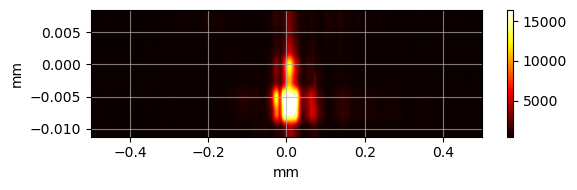

In [189]:
linecam.mask_flag = True
linecam.show_image()
plt.xlim(-0.5, 0.5)
linecam.mask_flag = True